Data cleaning

In [2]:
# ================================================================
# 📊 Norovirus Outbreak Descriptive Analysis (Restaurant-Associated)
# ================================================================

# --- 1️⃣ Install & import required packages ---
!pip install geopandas requests > /dev/null

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import requests, zipfile, io
import matplotlib.dates as mdates

# --- 2️⃣ Load NORS dataset (replace path if needed) ---
df = pd.read_csv("NORS.csv", low_memory=False)

# --- 3️⃣ Clean data types ---
df["Illnesses"] = pd.to_numeric(df["Illnesses"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
if "Month" in df.columns:
    df["Month"] = pd.to_numeric(df["Month"], errors="coerce")

# --- 4️⃣ Apply filters ---
mask = (
    df["Etiology"].str.contains("Norovirus", case=False, na=False)
    & df["Setting"].str.contains("Restaurant|Caterer|Banquet|Food", case=False, na=False)
    & df["Illnesses"].notnull()
    & (df["Illnesses"] > 0)
    & (df["Year"] >= 2009)
)

# Optional: include only foodborne/person-to-person/environmental transmission
if "Primary Mode" in df.columns:
    mask &= df["Primary Mode"].str.contains("Food|Person|Environmental", case=False, na=False)

df_filt = df.loc[mask, ["Year", "Month", "State", "Illnesses"]].copy()
print(f"✅ Filtered outbreaks: {len(df_filt)}")
display(df_filt.describe())

# ================================================================
# 5️⃣ Descriptive plots
# ================================================================

# --- Histogram of outbreak sizes ---
plt.figure(figsize=(7,4))
sns.histplot(df_filt["Illnesses"], bins=30, color="skyblue", edgecolor="k")
plt.title("Distribution of Restaurant Norovirus Outbreak Sizes")
plt.xlabel("Ill Persons per Outbreak")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- Year-wise trend ---
plt.figure(figsize=(8,4))
sns.countplot(x="Year", data=df_filt, color="coral")
plt.title("Restaurant Norovirus Outbreaks per Year (NORS)")
plt.xticks(rotation=45)
plt.ylabel("Number of Outbreaks")
plt.tight_layout()
plt.show()

# ================================================================
# 6️⃣ U.S. Heatmap by State
# ================================================================

# --- Download & read shapefile from U.S. Census (state boundaries) ---
url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("usa_shapefile")

us = gpd.read_file("usa_shapefile/cb_2022_us_state_5m.shp")

# Filter out non-continental territories
exclude = ["Puerto Rico", "Guam", "American Samoa", "Northern Mariana Islands", "Virgin Islands"]
us = us[~us["NAME"].isin(exclude)]
us = us.rename(columns={"NAME": "State"})

# --- Aggregate outbreak counts by state ---
state_counts = df_filt.groupby("State")["Illnesses"].count().reset_index(name="Outbreaks")

# Merge outbreak counts with geometry
merged = us.merge(state_counts, how="left", on="State")

# --- Plot the heatmap ---
fig, ax = plt.subplots(figsize=(10,6))
merged.plot(column="Outbreaks", cmap="YlOrRd", legend=True, ax=ax,
            legend_kwds={"label": "Outbreak Count"})
plt.title("Restaurant Norovirus Outbreaks by State (2009–present)")
plt.axis("off")
plt.tight_layout()
plt.show()

# ================================================================
# 7️⃣ Optional: Top 10 states table
# ================================================================
print("\n🏆 Top 10 States by Number of Outbreaks:")
display(state_counts.sort_values("Outbreaks", ascending=False).head(10))

# ================================================================
# 8️⃣ Monthly time series (Jan 2010 → latest) with COVID shading
# ================================================================

# --- Build datetime column from Year & Month ---
df_filt = df_filt.dropna(subset=["Year", "Month"])
df_filt["Month"] = df_filt["Month"].astype(int)
df_filt["Year"] = df_filt["Year"].astype(int)
df_filt["Date"] = pd.to_datetime(dict(year=df_filt["Year"], month=df_filt["Month"], day=1))

# --- Aggregate monthly outbreak count and total cases ---
monthly_ts = (
    df_filt.groupby("Date")
    .agg(outbreaks=("Illnesses", "count"),
         total_cases=("Illnesses", "sum"))
    .reset_index()
)

# --- Build continuous monthly timeline ---
all_months = pd.date_range(start="2010-01-01", end=monthly_ts["Date"].max(), freq="MS")
monthly_ts = (
    monthly_ts.set_index("Date")
    .reindex(all_months, fill_value=0)
    .rename_axis("Date")
    .reset_index()
)

# --- Force total_cases = 0 if no outbreaks (logic consistency) ---
monthly_ts.loc[monthly_ts["outbreaks"] == 0, "total_cases"] = 0

# --- Compute rolling averages (fixed version) ---
monthly_ts["outbreaks_rolling"] = (
    monthly_ts["outbreaks"]
    .rolling(window=3, center=True, min_periods=1)
    .mean()
)
monthly_ts["cases_rolling"] = (
    monthly_ts["total_cases"]
    .rolling(window=3, center=True, min_periods=1)
    .mean()
)
# Force both to zero when no outbreaks that month
monthly_ts.loc[monthly_ts["outbreaks"] == 0, ["outbreaks_rolling", "cases_rolling"]] = 0

# --- Plot dual-axis chart ---
fig, ax1 = plt.subplots(figsize=(10,5))

# Left axis: outbreaks
color1 = "tab:red"
ax1.bar(monthly_ts["Date"], monthly_ts["outbreaks"], width=25, color=color1, alpha=0.4, label="Outbreaks")
ax1.plot(monthly_ts["Date"], monthly_ts["outbreaks_rolling"], color=color1, linewidth=2)
ax1.set_ylabel("Number of Outbreaks", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

# Right axis: cases
ax2 = ax1.twinx()
color2 = "tab:blue"
ax2.plot(monthly_ts["Date"], monthly_ts["cases_rolling"], color=color2, linewidth=2, label="Total Cases (3-mo avg)")
ax2.set_ylabel("Total Cases Reported", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

# COVID shading (2020–2021)
ax1.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31"),
            color="gray", alpha=0.25, label="COVID-19 reporting disruption")

# Formatting
ax1.set_xlabel("Date")
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.title("Monthly Restaurant Norovirus Outbreaks and Cases (2010–Present)")
fig.tight_layout()
plt.legend(loc="upper left")
plt.show()

# --- Summary ---
print(f"Date range: {monthly_ts['Date'].min().date()} → {monthly_ts['Date'].max().date()}")
print(f"Total outbreaks recorded: {monthly_ts['outbreaks'].sum():,.0f}")
print(f"Total cases recorded: {monthly_ts['total_cases'].sum():,.0f}")

# ================================================================
# 9️⃣ Optional: Zoomed-in 2018–2023 section
# ================================================================
fig, ax1 = plt.subplots(figsize=(8,4))
focus = monthly_ts[(monthly_ts["Date"] >= "2018-01-01") & (monthly_ts["Date"] <= "2023-12-31")]

# Left axis — outbreaks
color1 = "tab:red"
ax1.bar(focus["Date"], focus["outbreaks"], width=25, color=color1, alpha=0.4, label="Outbreaks")
ax1.plot(focus["Date"], focus["outbreaks_rolling"], color=color1, linewidth=2)
ax1.set_ylabel("Number of Outbreaks", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

# Right axis — cases
ax2 = ax1.twinx()
color2 = "tab:blue"
ax2.plot(focus["Date"], focus["cases_rolling"], color=color2, linewidth=2, label="Total Cases (3-mo avg)")
ax2.set_ylabel("Total Cases Reported", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

# COVID shading
ax1.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31"),
            color="gray", alpha=0.25, label="COVID-19 reporting disruption")

# Formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.title("Restaurant Norovirus Outbreaks and Cases (2018–2023, Zoomed-in)")
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

# ================================================================
# 💾 10️⃣ Save Cleaned Dataset for Modeling
# ================================================================

df_filt.to_csv("NORS_clean.csv", index=False)
print(f"✅ Saved filtered dataset with {len(df_filt):,} rows to NORS_clean.csv")



KeyboardInterrupt: 

In [ ]:
# ================================================================
# 9️⃣ Monthly trends: outbreaks vs. total cases
# ================================================================

# --- Ensure 'Month' column exists and is numeric ---
if "Month" not in df_filt.columns and "Month" in df.columns:
    df_filt["Month"] = df.loc[df_filt.index, "Month"]

# Convert Month names or text to numbers (if needed)
df_filt["Month"] = pd.to_numeric(df_filt["Month"], errors="coerce")
df_filt = df_filt.dropna(subset=["Month"])
df_filt["Month"] = df_filt["Month"].astype(int)

# --- Aggregate by Month across all years ---
monthly = df_filt.groupby("Month").agg(
    outbreaks=("Illnesses", "count"),
    total_cases=("Illnesses", "sum")
).reset_index().sort_values("Month")

# --- Compute average cases per outbreak per month (optional) ---
monthly["avg_cases_per_outbreak"] = monthly["total_cases"] / monthly["outbreaks"]

# --- Dual-axis plot ---
fig, ax1 = plt.subplots(figsize=(8,5))

# Left axis: number of outbreaks
color1 = "tab:red"
ax1.bar(monthly["Month"], monthly["outbreaks"], color=color1, alpha=0.6, label="Outbreaks")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Outbreaks", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

# Right axis: total cases
ax2 = ax1.twinx()
color2 = "tab:blue"
ax2.plot(monthly["Month"], monthly["total_cases"], color=color2, marker="o", linewidth=2, label="Total Cases")
ax2.set_ylabel("Total Cases Reported", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

plt.title("Monthly Restaurant Norovirus Outbreaks and Total Cases (All Years Combined)")
fig.tight_layout()
plt.show()

# --- Optional: Average cases per outbreak plot ---
plt.figure(figsize=(7,4))
sns.lineplot(x="Month", y="avg_cases_per_outbreak", data=monthly, marker="o", color="green")
plt.title("Average Cases per Outbreak by Month")
plt.xticks(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.ylabel("Mean Cases per Outbreak")
plt.tight_layout()
plt.show()


# Stochastic SEIRX Restaurant Norovirus Model — Default Scenario (A)


In [ ]:
# Stochastic SEIRX Restaurant Norovirus Model — Default Scenario (A)
# Gillespie simulation with no hygiene or exclusion

import numpy as np
import matplotlib.pyplot as plt

def simulate_seirx_gillespie(
    N_staff=20,
    N_patrons=100,
    init_infectious_staff=3,
    sigma=0.67,
    gamma=0.5,
    beta_ss=1.2,
    beta_sp=1.0,
    beta_ps=1.0,
    beta_pp=0.6,
    # Policy OFF
    beta_mult=1.0,    # no hygiene scaling
    compliance=0.0,   # no one complies
    xi_max=0.0,       # no exclusion
    omega=0.2,
    T_max=30.0,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # Apply compliance adjustments
    xi = xi_max * compliance                      # effective exclusion rate = 0
    beta_scale = 1.0 - (1.0 - beta_mult) * compliance  # = 1.0 → no change
    beta_ss *= beta_scale
    beta_sp *= beta_scale
    beta_ps *= beta_scale
    beta_pp *= beta_scale

    # Initial state
    S_s, E_s, I_s, R_s, X_s = N_staff - init_infectious_staff, 0, init_infectious_staff, 0, 0
    S_p, E_p, I_p, R_p = N_patrons, 0, 0, 0

    t = 0.0
    times = [t]
    history = [(S_s, E_s, I_s, R_s, X_s, S_p, E_p, I_p, R_p)]

    while t < T_max and (I_s + I_p + E_s + E_p) > 0:
        pop_total = max(1, N_staff + N_patrons)
        lambda_s = (beta_ss * I_s + beta_ps * I_p) / pop_total
        lambda_p = (beta_sp * I_s + beta_pp * I_p) / pop_total

        rates = [
            lambda_s * S_s,
            sigma * E_s,
            gamma * I_s,
            xi * I_s,
            omega * X_s,
            lambda_p * S_p,
            sigma * E_p,
            gamma * I_p
        ]

        total_rate = sum(rates)
        if total_rate <= 0:
            break

        dt = np.random.exponential(1.0 / total_rate)
        t += dt

        r = np.random.rand() * total_rate
        cumulative = 0.0
        event = None
        for i, rate in enumerate(rates):
            cumulative += rate
            if r <= cumulative:
                event = i
                break

        if event == 0 and S_s > 0:
            S_s -= 1; E_s += 1
        elif event == 1 and E_s > 0:
            E_s -= 1; I_s += 1
        elif event == 2 and I_s > 0:
            I_s -= 1; R_s += 1
        elif event == 3 and I_s > 0:
            I_s -= 1; X_s += 1
        elif event == 4 and X_s > 0:
            X_s -= 1; R_s += 1
        elif event == 5 and S_p > 0:
            S_p -= 1; E_p += 1
        elif event == 6 and E_p > 0:
            E_p -= 1; I_p += 1
        elif event == 7 and I_p > 0:
            I_p -= 1; R_p += 1

        times.append(t)
        history.append((S_s, E_s, I_s, R_s, X_s, S_p, E_p, I_p, R_p))

    times = np.array(times)
    history = np.array(history)

    peak_Ip = int(history[:, 7].max())
    peak_Is = int(history[:, 2].max())
    total_cases = int((N_staff - history[-1, 0]) + (N_patrons - history[-1, 5]))

    metrics = {
        "peak_infectious_patrons": peak_Ip,
        "peak_infectious_staff": peak_Is,
        "total_cases": total_cases,
        "final_state": history[-1].tolist(),
        "duration_days": float(times[-1]) if len(times)>0 else 0.0,
        "params": {
            "beta_ss": beta_ss, "beta_sp": beta_sp, "beta_ps": beta_ps, "beta_pp": beta_pp,
            "xi": xi, "omega": omega, "beta_mult_effective": beta_scale, "compliance": compliance
        }
    }

    return times, history, metrics


# ----------------------------
# Run the default (no policy) simulation (Scenario A)
# ----------------------------
times_a, history_a, metrics_a = simulate_seirx_gillespie(
    N_staff=20,
    N_patrons=100,
    init_infectious_staff=3,
    sigma=0.67,
    gamma=0.5,
    beta_ss=1.2,
    beta_sp=1.0,
    beta_ps=1.0,
    beta_pp=0.6,
    beta_mult=1.0,     # no hygiene
    compliance=0.0,    # no compliance
    xi_max=0.0,        # no exclusion
    omega=0.2,
    T_max=30.0,
    seed=42
)

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(10,6))
plt.step(times_a, history_a[:,2], where='post', color='firebrick', label='Infectious Staff (Iₛ)')
plt.step(times_a, history_a[:,7], where='post', color='royalblue', label='Infectious Patrons (Iₚ)')
plt.step(times_a, history_a[:,4], where='post', color='orange', label='Excluded Staff (Xₛ)')
plt.xlabel("Time (days)")
plt.ylabel("Individuals")
plt.title("Scenario A — Default (No Policies)\n(Gillespie SEIRX)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Summary metrics
# ----------------------------
print("=== Scenario A (No Policy) Summary ===")
print(f"Peak infectious patrons: {metrics_a['peak_infectious_patrons']}")
print(f"Peak infectious staff:   {metrics_a['peak_infectious_staff']}")
print(f"Total cases (staff+patrons): {metrics_a['total_cases']}")
print(f"Simulated duration (days): {metrics_a['duration_days']:.2f}")


# Stochastic SEIRX Restaurant Norovirus Model — Policy Scenario (B)


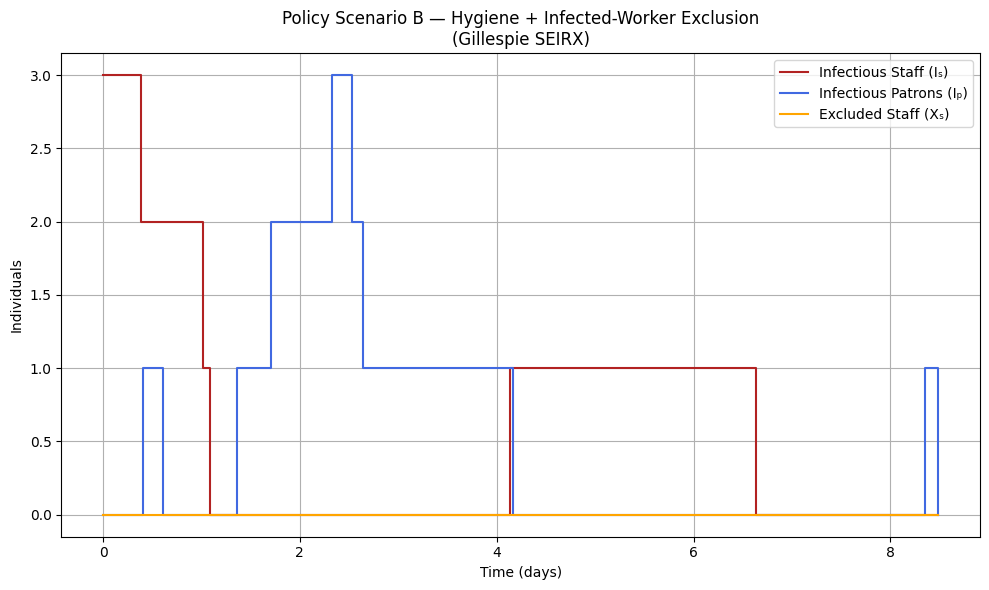

=== Scenario B (Policy) Summary ===
Peak infectious patrons: 3
Peak infectious staff:   3
Total cases (staff+patrons): 9
Simulated duration (days): 8.49
Effective parameters used (post-compliance/hygiene scaling):
  beta_ss: 0.9119999999999999
  beta_sp: 0.76
  beta_ps: 0.76
  beta_pp: 0.45599999999999996
  xi: 0.24
  omega: 0.2
  beta_mult_effective: 0.76
  compliance: 0.6


In [1]:
# Stochastic SEIRX Restaurant Norovirus Model — Policy Scenario (B)
# Gillespie simulation with hygiene + infected-worker exclusion (single-run)
# Run in Google Colab / Jupyter

import numpy as np
import matplotlib.pyplot as plt

def simulate_seirx_gillespie(
    N_staff=20,
    N_patrons=100,
    init_infectious_staff=3,
    sigma=0.67,
    gamma=0.5,
    beta_ss=1.2,
    beta_sp=1.0,
    beta_ps=1.0,
    beta_pp=0.6,
    # Policy params (Policy B: hygiene + exclusion)
    beta_mult=0.6,   # hygiene multiplier (0<beta_mult<=1, 1=no effect)
    compliance=0.6,  # fraction of staff complying with policies, applied to effective exclusion & hygiene
    xi_max=0.4,      # max exclusion rate per day (if fully compliant)
    omega=0.2,       # return-to-work rate per day from excluded compartment
    T_max=30.0,
    seed=None,
):
    """
    Returns: times (np.array), history (np.array shape (n_steps, 9)), metrics dict
    history columns: S_s, E_s, I_s, R_s, X_s, S_p, E_p, I_p, R_p
    """
    if seed is not None:
        np.random.seed(seed)

    # Apply compliance adjustments
    xi = xi_max * compliance                      # effective exclusion rate
    # compliance-adjusted hygiene on beta: beta_eff = beta * (1 - (1 - beta_mult)*compliance)
    beta_scale = 1.0 - (1.0 - beta_mult) * compliance
    beta_ss *= beta_scale
    beta_sp *= beta_scale
    beta_ps *= beta_scale
    beta_pp *= beta_scale

    # Initial state
    S_s, E_s, I_s, R_s, X_s = N_staff - init_infectious_staff, 0, init_infectious_staff, 0, 0
    S_p, E_p, I_p, R_p = N_patrons, 0, 0, 0

    t = 0.0
    times = [t]
    history = [(S_s, E_s, I_s, R_s, X_s, S_p, E_p, I_p, R_p)]

    while t < T_max and (I_s + I_p + E_s + E_p) > 0:
        # Force of infection per susceptible (scaled by total population for mixing)
        pop_total = max(1, N_staff + N_patrons)
        lambda_s = (beta_ss * I_s + beta_ps * I_p) / pop_total
        lambda_p = (beta_sp * I_s + beta_pp * I_p) / pop_total

        # Event rates
        rates = [
            lambda_s * S_s,     # 0: staff infection (S_s -> E_s)
            sigma * E_s,        # 1: staff incubation (E_s -> I_s)
            gamma * I_s,        # 2: staff recovery (I_s -> R_s)
            xi * I_s,           # 3: staff exclusion (I_s -> X_s)
            omega * X_s,        # 4: return from exclusion (X_s -> R_s)
            lambda_p * S_p,     # 5: patron infection (S_p -> E_p)
            sigma * E_p,        # 6: patron incubation (E_p -> I_p)
            gamma * I_p         # 7: patron recovery (I_p -> R_p)
        ]

        total_rate = sum(rates)
        if total_rate <= 0:
            break

        # time to next event
        dt = np.random.exponential(1.0 / total_rate)
        t += dt

        # choose event
        r = np.random.rand() * total_rate
        cumulative = 0.0
        event = None
        for i, rate in enumerate(rates):
            cumulative += rate
            if r <= cumulative:
                event = i
                break

        # apply event with guards (check counts)
        if event == 0 and S_s > 0:
            S_s -= 1; E_s += 1
        elif event == 1 and E_s > 0:
            E_s -= 1; I_s += 1
        elif event == 2 and I_s > 0:
            I_s -= 1; R_s += 1
        elif event == 3 and I_s > 0:
            I_s -= 1; X_s += 1
        elif event == 4 and X_s > 0:
            X_s -= 1; R_s += 1
        elif event == 5 and S_p > 0:
            S_p -= 1; E_p += 1
        elif event == 6 and E_p > 0:
            E_p -= 1; I_p += 1
        elif event == 7 and I_p > 0:
            I_p -= 1; R_p += 1
        # otherwise skip (should be rare because rates reflect availability)

        # record
        times.append(t)
        history.append((S_s, E_s, I_s, R_s, X_s, S_p, E_p, I_p, R_p))

    times = np.array(times)
    history = np.array(history)

    peak_Ip = int(history[:, 7].max())
    peak_Is = int(history[:, 2].max())
    total_cases = int((N_staff - history[-1, 0]) + (N_patrons - history[-1, 5]))

    metrics = {
        "peak_infectious_patrons": peak_Ip,
        "peak_infectious_staff": peak_Is,
        "total_cases": total_cases,
        "final_state": history[-1].tolist(),
        "duration_days": float(times[-1]) if len(times)>0 else 0.0,
        "params": {
            "beta_ss": beta_ss, "beta_sp": beta_sp, "beta_ps": beta_ps, "beta_pp": beta_pp,
            "xi": xi, "omega": omega, "beta_mult_effective": beta_scale, "compliance": compliance
        }
    }

    return times, history, metrics


# ----------------------------
# Run the policy simulation (Scenario B)
# ----------------------------
times, history, metrics = simulate_seirx_gillespie(
    N_staff=20,
    N_patrons=100,
    init_infectious_staff=3,
    sigma=0.67,
    gamma=0.5,
    beta_ss=1.2,
    beta_sp=1.0,
    beta_ps=1.0,
    beta_pp=0.6,
    beta_mult=0.6,     # hygiene (40% reduction)
    compliance=0.6,    # 60% of staff comply
    xi_max=0.4,        # up to 0.4/day exclusion when fully compliant
    omega=0.2,
    T_max=30.0,
    seed=42
)

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(10,6))
plt.step(times, history[:,2], where='post', color='firebrick', label='Infectious Staff (Iₛ)')
plt.step(times, history[:,7], where='post', color='royalblue', label='Infectious Patrons (Iₚ)')
plt.step(times, history[:,4], where='post', color='orange', label='Excluded Staff (Xₛ)')
plt.xlabel("Time (days)")
plt.ylabel("Individuals")
plt.title("Policy Scenario B — Hygiene + Infected-Worker Exclusion\n(Gillespie SEIRX)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Summary metrics
# ----------------------------
print("=== Scenario B (Policy) Summary ===")
print(f"Peak infectious patrons: {metrics['peak_infectious_patrons']}")
print(f"Peak infectious staff:   {metrics['peak_infectious_staff']}")
print(f"Total cases (staff+patrons): {metrics['total_cases']}")
print(f"Simulated duration (days): {metrics['duration_days']:.2f}")
print("Effective parameters used (post-compliance/hygiene scaling):")
for k,v in metrics["params"].items():
    print(f"  {k}: {v}")


SEIRX Final

SIMPLIFIED RESTAURANT OUTBREAK MODEL

Running Scenario 1: No Policy (Baseline)...

SCENARIO 1: No Policy (Baseline)
Results from 100 simulations:

peak_infectious_staff    : median=   4.0, IQR=(   3.0,    6.0), mean±sd=   4.7±  1.6
staff_cases              : median=  14.0, IQR=(   8.0,   17.0), mean±sd=  12.5±  5.2
patron_cases             : median=  95.0, IQR=(  42.8,  137.2), mean±sd=  96.9± 61.0
total_cases              : median= 108.5, IQR=(  52.5,  154.5), mean±sd= 109.4± 65.8
duration_days            : median=  12.2, IQR=(   8.2,   16.6), mean±sd=  12.0±  6.3
peak_excluded            : median=   0.0, IQR=(   0.0,    0.0), mean±sd=   0.0±  0.0

Running Scenario 2: 60% Compliance...

SCENARIO 2: 60% Compliance, Moderate Intervention
Results from 100 simulations:

peak_infectious_staff    : median=   3.0, IQR=(   3.0,    4.0), mean±sd=   3.4±  0.9
staff_cases              : median=   6.0, IQR=(   4.0,    9.2), mean±sd=   7.3±  4.3
patron_cases             : median=  20.0, IQR=(   9.

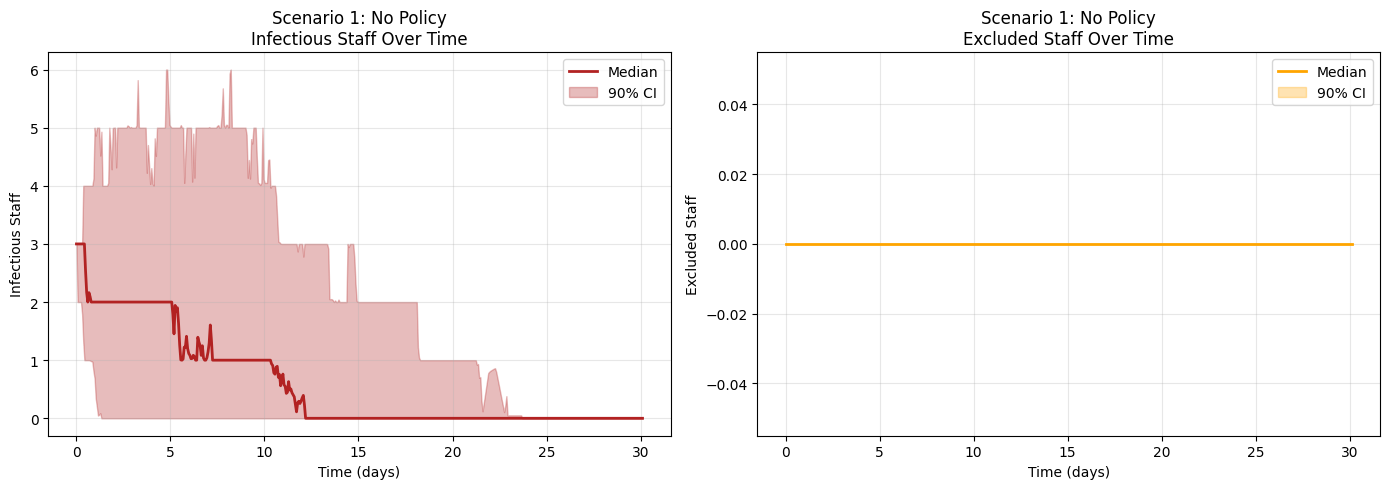

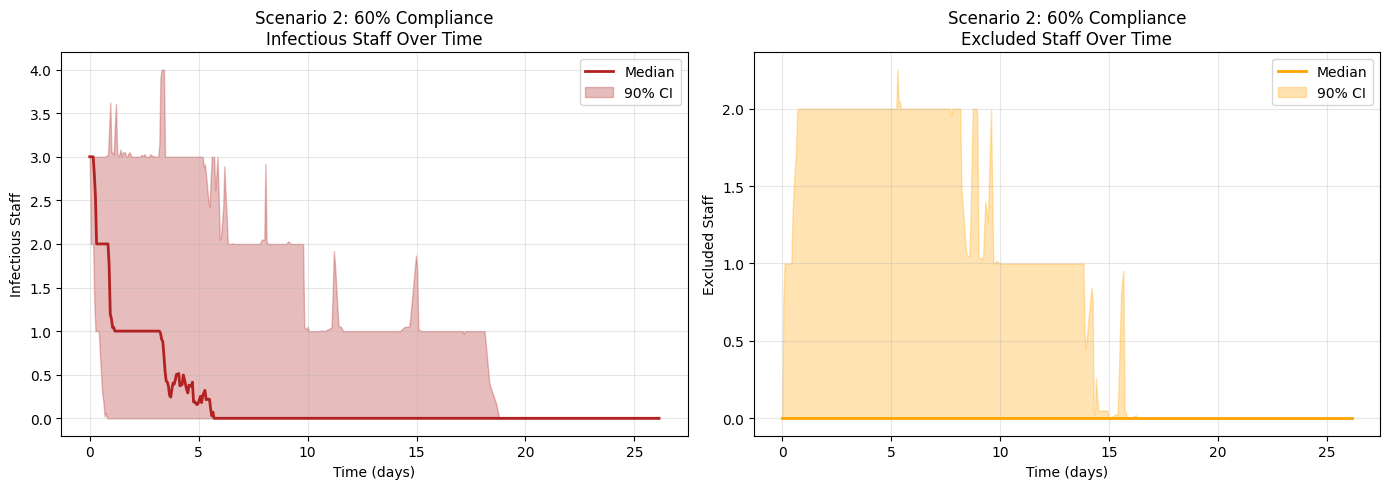

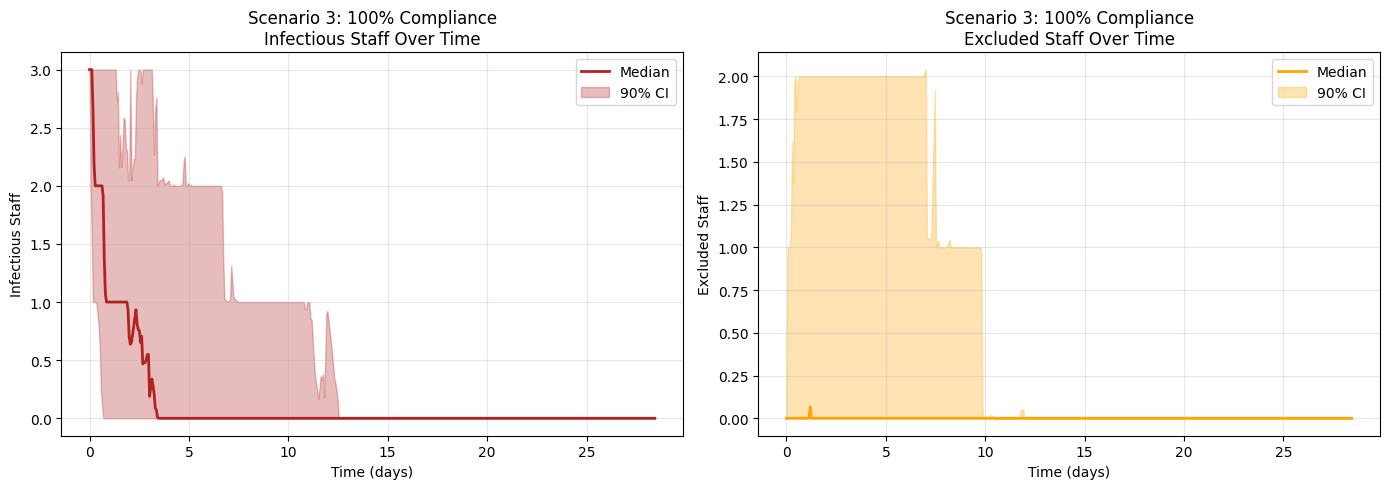

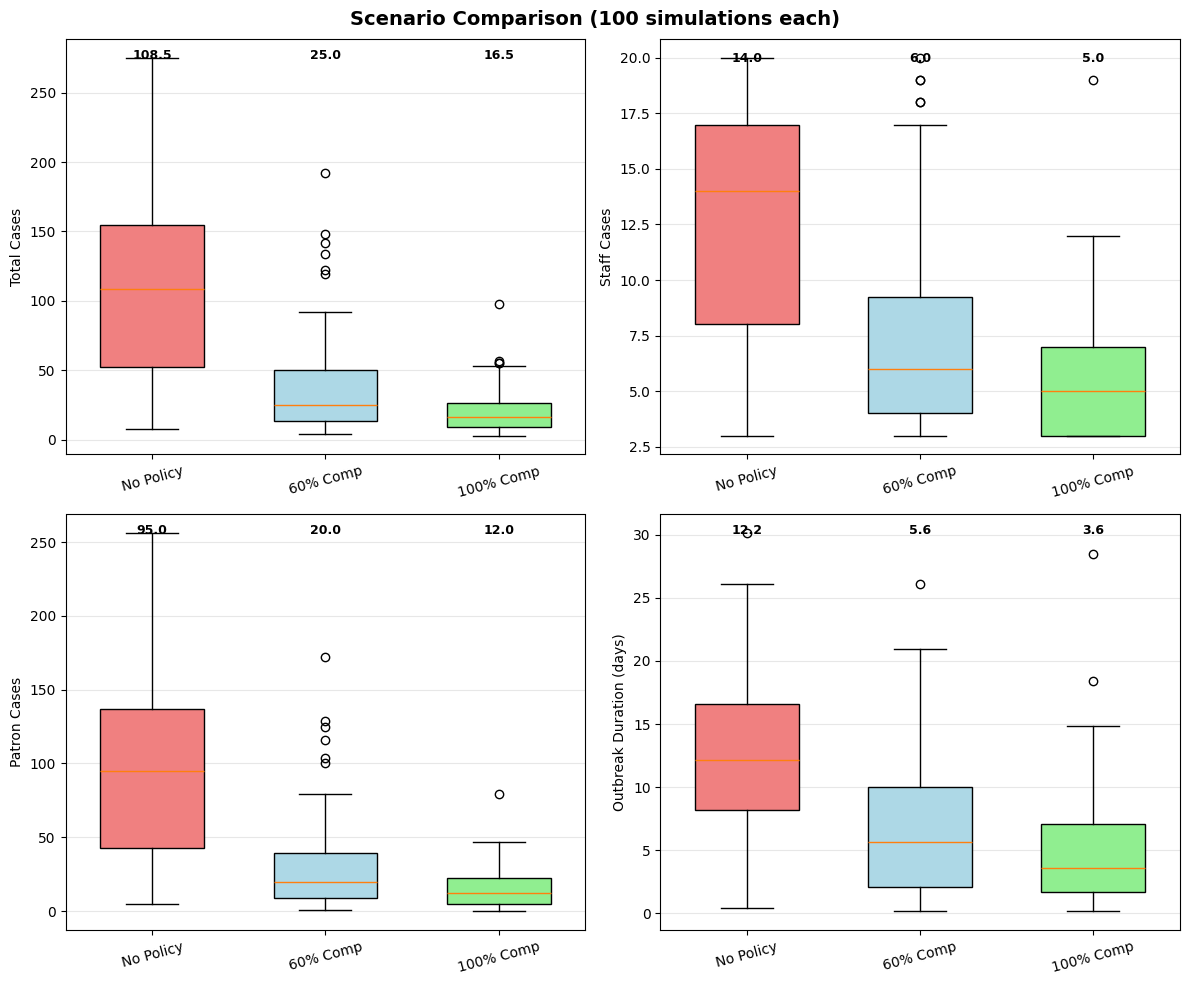


Analysis complete!


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class ModelParams:
    """Parameters for the simplified restaurant outbreak model"""
    # Population
    N_staff: int = 20
    patrons_per_hour: float = 10.0  # Patron arrival rate
    patron_visit_duration: float = 2.0  # hours (typical meal duration)

    # Disease parameters
    sigma: float = 0.67  # 1/latent period (1.5 days)
    gamma: float = 0.5   # 1/infectious period (2 days)
    p_symptomatic: float = 0.7  # Fraction developing symptoms

    # Transmission rates (per day)
    beta_ss: float = 0.9   # Staff to staff (reduced from 1.2)
    beta_sp: float = 4.0   # Staff to patron (reduced from 8.0)

    # Policy parameters
    compliance_rate: float = 0.0  # Fraction of staff complying with policies
    hygiene_effectiveness: float = 0.0  # Reduction in transmission (0 = no effect, 0.4 = 40% reduction)
    exclusion_rate: float = 0.0  # Rate symptomatic compliant staff are excluded (/day)
    return_rate: float = 0.2  # Return to work rate after exclusion (/day)

    # Simulation
    T_max: float = 30.0
    init_infectious_staff: int = 3

class SimplifiedRestaurantModel:
    """Simplified stochastic SEIRX model"""

    def __init__(self, params: ModelParams, seed: int = None):
        self.p = params
        if seed is not None:
            np.random.seed(seed)

        # Calculate effective transmission reduction
        self.transmission_mult = 1.0 - (params.compliance_rate * params.hygiene_effectiveness)

        # Staff compartments
        self.S = params.N_staff - params.init_infectious_staff
        self.E = 0
        self.Ia = 0  # Asymptomatic infectious
        self.Is = params.init_infectious_staff  # Symptomatic infectious
        self.X = 0   # Excluded (can only happen if compliant)
        self.R = 0

        # Patron exposure tracking
        self.patron_infections = 0

        # History
        self.t = 0.0
        self.times = [self.t]
        self.history = [self._get_state()]

    def _get_state(self):
        """Return current state as tuple"""
        total_I = self.Ia + self.Is
        return (self.S, self.E, self.Ia, self.Is, self.X, self.R,
                self.patron_infections, total_I)

    def _get_total_infectious(self):
        """Total infectious staff"""
        return self.Ia + self.Is

    def _compute_foi_staff(self):
        """Force of infection for staff"""
        I_total = self._get_total_infectious()
        N_staff = self.p.N_staff

        # Staff-to-staff transmission with hygiene effectiveness
        foi = (self.p.beta_ss * self.transmission_mult * I_total / N_staff)

        return foi

    def _compute_foi_patron(self):
        """Force of infection for patrons during their visit"""
        I_total = self._get_total_infectious()
        N_staff = self.p.N_staff

        # Staff-to-patron transmission (frequency dependent)
        # Convert daily rate to hourly, then scale by visit duration
        foi_hourly = (self.p.beta_sp * self.transmission_mult * I_total / N_staff) / 24.0
        foi_visit = foi_hourly * self.p.patron_visit_duration

        return foi_visit

    def _compute_rates(self):
        """Compute all event rates"""
        foi_staff = self._compute_foi_staff()
        foi_patron = self._compute_foi_patron()

        # Exclusion only happens to fraction of symptomatic that are compliant
        effective_exclusion_rate = self.p.exclusion_rate * self.p.compliance_rate

        rates = {
            # Staff infections
            'S_to_E': foi_staff * self.S,
            'E_to_Ia': self.p.sigma * (1 - self.p.p_symptomatic) * self.E,
            'E_to_Is': self.p.sigma * self.p.p_symptomatic * self.E,
            'Ia_to_R': self.p.gamma * self.Ia,
            'Is_to_R': self.p.gamma * self.Is,
            'Is_to_X': effective_exclusion_rate * self.Is,
            'X_to_R': self.p.return_rate * self.X,

            # Patron infections (flow model)
            # patrons_per_hour arrivals, each with foi_patron infection risk
            # Convert to daily rate
            'patron_infection': self.p.patrons_per_hour * 24.0 * foi_patron,
        }

        return rates

    def _apply_event(self, event: str):
        """Apply the selected event"""
        if event == 'S_to_E' and self.S > 0:
            self.S -= 1
            self.E += 1
        elif event == 'E_to_Ia' and self.E > 0:
            self.E -= 1
            self.Ia += 1
        elif event == 'E_to_Is' and self.E > 0:
            self.E -= 1
            self.Is += 1
        elif event == 'Ia_to_R' and self.Ia > 0:
            self.Ia -= 1
            self.R += 1
        elif event == 'Is_to_R' and self.Is > 0:
            self.Is -= 1
            self.R += 1
        elif event == 'Is_to_X' and self.Is > 0:
            self.Is -= 1
            self.X += 1
        elif event == 'X_to_R' and self.X > 0:
            self.X -= 1
            self.R += 1
        elif event == 'patron_infection':
            self.patron_infections += 1

    def run(self):
        """Run Gillespie simulation"""
        while self.t < self.p.T_max:
            # Check stopping condition
            if self._get_total_infectious() == 0 and self.E == 0:
                break

            rates = self._compute_rates()
            total_rate = sum(rates.values())

            if total_rate <= 0:
                break

            # Time to next event
            dt = np.random.exponential(1.0 / total_rate)
            self.t += dt

            # Select event
            r = np.random.rand() * total_rate
            cumsum = 0.0
            selected_event = None
            for event, rate in rates.items():
                cumsum += rate
                if r <= cumsum:
                    selected_event = event
                    break

            # Apply event
            if selected_event:
                self._apply_event(selected_event)

            # Record state
            self.times.append(self.t)
            self.history.append(self._get_state())

        return np.array(self.times), np.array(self.history)

    def get_metrics(self):
        """Compute summary metrics"""
        history = np.array(self.history)

        # Peak infectious staff
        peak_I = int(history[:, 7].max())  # Total I column

        # Total staff cases
        final_S = int(history[-1, 0])
        staff_cases = self.p.N_staff - final_S

        # Total patron infections
        patron_cases = int(history[-1, 6])

        # Total cases
        total_cases = staff_cases + patron_cases

        # Duration
        duration = self.times[-1] if len(self.times) > 0 else 0.0

        # Peak excluded
        peak_excluded = int(history[:, 4].max())

        return {
            'peak_infectious_staff': peak_I,
            'staff_cases': staff_cases,
            'patron_cases': patron_cases,
            'total_cases': total_cases,
            'duration_days': duration,
            'peak_excluded': peak_excluded,
        }


def run_monte_carlo(params: ModelParams, n_sims: int = 100):
    """Run multiple simulations and return results"""
    results = []
    all_times = []
    all_histories = []

    for seed in range(n_sims):
        model = SimplifiedRestaurantModel(params, seed=seed)
        times, history = model.run()
        metrics = model.get_metrics()

        results.append(metrics)
        all_times.append(times)
        all_histories.append(history)

    return results, all_times, all_histories


def summarize_results(results: List[dict], scenario_name: str):
    """Print summary statistics from Monte Carlo runs"""
    metrics_keys = ['peak_infectious_staff', 'staff_cases', 'patron_cases',
                    'total_cases', 'duration_days', 'peak_excluded']

    print(f"\n{'='*60}")
    print(f"{scenario_name}")
    print(f"{'='*60}")
    print(f"Results from {len(results)} simulations:\n")

    for key in metrics_keys:
        values = [r[key] for r in results]
        median = np.median(values)
        q25 = np.percentile(values, 25)
        q75 = np.percentile(values, 75)
        mean = np.mean(values)
        std = np.std(values)

        print(f"{key:25s}: median={median:6.1f}, IQR=({q25:6.1f}, {q75:6.1f}), mean±sd={mean:6.1f}±{std:5.1f}")


def plot_monte_carlo_results(all_times, all_histories, scenario_name: str):
    """Plot median trajectory with 95% CI bands"""
    # Interpolate all trajectories to common time grid
    max_time = max(times[-1] for times in all_times if len(times) > 0)
    time_grid = np.linspace(0, max_time, 500)

    # Interpolate infectious staff (column 7) and excluded (column 4)
    infectious_trajectories = []
    excluded_trajectories = []

    for times, history in zip(all_times, all_histories):
        if len(times) > 1:
            infectious_interp = np.interp(time_grid, times, history[:, 7], left=0, right=0)
            excluded_interp = np.interp(time_grid, times, history[:, 4], left=0, right=0)
            infectious_trajectories.append(infectious_interp)
            excluded_trajectories.append(excluded_interp)

    infectious_trajectories = np.array(infectious_trajectories)
    excluded_trajectories = np.array(excluded_trajectories)

    # Compute percentiles
    median_infectious = np.median(infectious_trajectories, axis=0)
    p5_infectious = np.percentile(infectious_trajectories, 5, axis=0)
    p95_infectious = np.percentile(infectious_trajectories, 95, axis=0)

    median_excluded = np.median(excluded_trajectories, axis=0)
    p5_excluded = np.percentile(excluded_trajectories, 5, axis=0)
    p95_excluded = np.percentile(excluded_trajectories, 95, axis=0)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Infectious staff
    ax1.plot(time_grid, median_infectious, color='firebrick', linewidth=2, label='Median')
    ax1.fill_between(time_grid, p5_infectious, p95_infectious, color='firebrick', alpha=0.3, label='90% CI')
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Infectious Staff')
    ax1.set_title(f'{scenario_name}\nInfectious Staff Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Excluded staff
    ax2.plot(time_grid, median_excluded, color='orange', linewidth=2, label='Median')
    ax2.fill_between(time_grid, p5_excluded, p95_excluded, color='orange', alpha=0.3, label='90% CI')
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Excluded Staff')
    ax2.set_title(f'{scenario_name}\nExcluded Staff Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def plot_comparison(results_list, scenario_names):
    """Compare distributions between multiple scenarios"""
    n_scenarios = len(results_list)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    metrics = [
        ('total_cases', 'Total Cases', axes[0, 0]),
        ('staff_cases', 'Staff Cases', axes[0, 1]),
        ('patron_cases', 'Patron Cases', axes[1, 0]),
        ('duration_days', 'Outbreak Duration (days)', axes[1, 1])
    ]

    colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']

    for metric_key, metric_name, ax in metrics:
        data = [[r[metric_key] for r in results] for results in results_list]

        positions = list(range(1, n_scenarios + 1))
        bp = ax.boxplot(data, positions=positions, widths=0.6,
                        patch_artist=True, tick_labels=scenario_names)

        # Color boxes
        for patch, color in zip(bp['boxes'], colors[:n_scenarios]):
            patch.set_facecolor(color)

        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', rotation=15)

        # Add median values as text
        for i, (pos, d) in enumerate(zip(positions, data)):
            med = np.median(d)
            ax.text(pos, ax.get_ylim()[1]*0.95, f'{med:.1f}',
                   ha='center', fontsize=9, fontweight='bold')

    plt.suptitle(f'Scenario Comparison ({len(results_list[0])} simulations each)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # Number of Monte Carlo simulations
    N_SIMS = 100

    print("="*60)
    print("SIMPLIFIED RESTAURANT OUTBREAK MODEL")
    print("="*60)

    # Scenario 1: No Policy (baseline)
    print("\nRunning Scenario 1: No Policy (Baseline)...")
    params_1 = ModelParams(
        N_staff=20,
        compliance_rate=0.0,
        hygiene_effectiveness=0.0,
        exclusion_rate=0.0,
        init_infectious_staff=3
    )
    results_1, times_1, histories_1 = run_monte_carlo(params_1, N_SIMS)
    summarize_results(results_1, "SCENARIO 1: No Policy (Baseline)")

    # Scenario 2: 60% Compliance with moderate intervention
    print("\nRunning Scenario 2: 60% Compliance...")
    params_2 = ModelParams(
        N_staff=20,
        compliance_rate=0.6,
        hygiene_effectiveness=0.4,  # 40% reduction in transmission
        exclusion_rate=0.4,  # Exclude at 0.4/day
        init_infectious_staff=3
    )
    results_2, times_2, histories_2 = run_monte_carlo(params_2, N_SIMS)
    summarize_results(results_2, "SCENARIO 2: 60% Compliance, Moderate Intervention")

    # Scenario 3: 100% Compliance with strong intervention
    print("\nRunning Scenario 3: 100% Compliance...")
    params_3 = ModelParams(
        N_staff=20,
        compliance_rate=1.0,
        hygiene_effectiveness=0.4,  # 40% reduction in transmission (reduced from 0.6)
        exclusion_rate=0.4,  # Exclusion rate (reduced from 0.6)
        init_infectious_staff=3
    )
    results_3, times_3, histories_3 = run_monte_carlo(params_3, N_SIMS)
    summarize_results(results_3, "SCENARIO 3: 100% Compliance, Moderate Intervention")

    # Plot individual scenarios
    print("\nGenerating plots...")
    fig1 = plot_monte_carlo_results(times_1, histories_1, "Scenario 1: No Policy")
    fig2 = plot_monte_carlo_results(times_2, histories_2, "Scenario 2: 60% Compliance")
    fig3 = plot_monte_carlo_results(times_3, histories_3, "Scenario 3: 100% Compliance")

    # Comparison plot
    fig_comp = plot_comparison(
        [results_1, results_2, results_3],
        ['No Policy', '60% Comp', '100% Comp']
    )

    plt.show()

    print("\n" + "="*60)
    print("Analysis complete!")
    print("="*60)

Google trends